In [1]:
# Advanced use of recurrent neural networks

In [2]:
# Recurrent dropout — This is a specific, built-in way to use dropout to fight overfitting in recurrent layers.
# Stacking recurrent layers—This increases the representational power of the network (at the cost of higher computational loads).
# Bidirectional recurrent layers—These present the same information to a recurrent network in different ways, increasing accuracy and mitigating forgetting issues.

In [3]:
import os


data_dir = 'climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [4]:
import numpy as np


float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

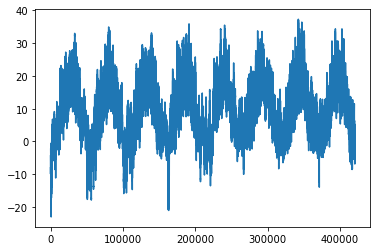

In [5]:
import matplotlib.pyplot as plt


temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

In [6]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

print(float_data.shape)  # shape(420451, 14)

(420451, 14)


In [7]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [8]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)
val_steps = min(500, (300000 - 200001 - lookback))
test_steps = (len(float_data) - 300001 - lookback)

In [9]:
# A common-sense, non-machine-learning baseline

def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))


evaluate_naive_method()

0.2857543010182409


In [10]:
# A basic machine-learning approach

In [11]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop


model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

2022-08-17 12:15:42.367254: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-17 12:15:42.371188: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
/tmp/ipykernel_246330/892506889.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


Epoch 1/20
500/500 [==============================] - 26s 52ms/step - loss: 1.4181 - val_loss: 0.6520
Epoch 2/20
500/500 [==============================] - 25s 51ms/step - loss: 0.4758 - val_loss: 0.3194
Epoch 3/20
500/500 [==============================] - 29s 58ms/step - loss: 0.2938 - val_loss: 0.3306
Epoch 4/20
500/500 [==============================] - 31s 62ms/step - loss: 0.2696 - val_loss: 0.2959
Epoch 5/20
500/500 [==============================] - 31s 62ms/step - loss: 0.2534 - val_loss: 0.3198
Epoch 6/20
500/500 [==============================] - 28s 56ms/step - loss: 0.2464 - val_loss: 0.3297
Epoch 7/20
500/500 [==============================] - 32s 64ms/step - loss: 0.2393 - val_loss: 0.3171
Epoch 8/20
500/500 [==============================] - 30s 60ms/step - loss: 0.2337 - val_loss: 0.3198
Epoch 9/20
500/500 [==============================] - 31s 61ms/step - loss: 0.2299 - val_loss: 0.3167
Epoch 10/20
500/500 [==============================] - 32s 64ms/step - loss: 0.225

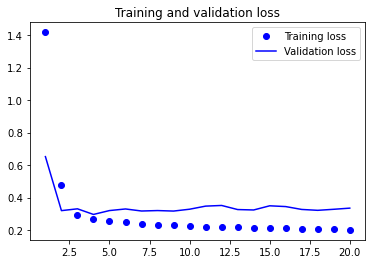

In [12]:
import matplotlib.pyplot as plt


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [13]:
# A first recurrent baseline

In [14]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop


model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20


/tmp/ipykernel_246330/3266505108.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 175s 347ms/step - loss: 0.3021 - val_loss: 0.2696
Epoch 2/20
500/500 [==============================] - 178s 357ms/step - loss: 0.2824 - val_loss: 0.2761
Epoch 3/20
500/500 [==============================] - 181s 362ms/step - loss: 0.2784 - val_loss: 0.2614
Epoch 4/20
500/500 [==============================] - 175s 349ms/step - loss: 0.2740 - val_loss: 0.2618
Epoch 5/20
500/500 [==============================] - 176s 353ms/step - loss: 0.2688 - val_loss: 0.2703
Epoch 6/20
500/500 [==============================] - 169s 339ms/step - loss: 0.2653 - val_loss: 0.2541
Epoch 7/20
500/500 [==============================] - 184s 369ms/step - loss: 0.2590 - val_loss: 0.2592
Epoch 8/20
500/500 [==============================] - 183s 365ms/step - loss: 0.2546 - val_loss: 0.2789
Epoch 9/20
500/500 [==============================] - 176s 353ms/step - loss: 0.2496 - val_loss: 0.2588
Epoch 10/20
500/500 [==============================] - 171s 342ms/step - lo

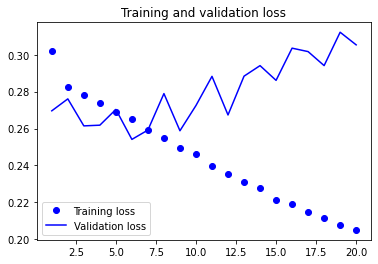

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [16]:
# Using recurrent dropout to fight overfitting

In [21]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop


model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40


/tmp/ipykernel_246330/3699084108.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 297s 590ms/step - loss: 0.3220 - val_loss: 0.2752
Epoch 2/40
500/500 [==============================] - 287s 575ms/step - loss: 0.3094 - val_loss: 0.2852
Epoch 3/40
500/500 [==============================] - 285s 570ms/step - loss: 0.2988 - val_loss: 0.2768
Epoch 4/40
500/500 [==============================] - 287s 574ms/step - loss: 0.2934 - val_loss: 0.2683
Epoch 5/40
500/500 [==============================] - 289s 578ms/step - loss: 0.2884 - val_loss: 0.2732
Epoch 6/40
500/500 [==============================] - 300s 601ms/step - loss: 0.2873 - val_loss: 0.2676
Epoch 7/40
500/500 [==============================] - 291s 583ms/step - loss: 0.2813 - val_loss: 0.2676
Epoch 8/40
500/500 [==============================] - 289s 579ms/step - loss: 0.2777 - val_loss: 0.2789
Epoch 9/40
500/500 [==============================] - 295s 589ms/step - loss: 0.2737 - val_loss: 0.2734
Epoch 10/40
500/500 [==============================] - 316s 633ms/step - lo

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 383s 767ms/step - loss: 0.2619 - val_loss: 0.2834
Epoch 15/40
500/500 [==============================] - 301s 603ms/step - loss: 0.2595 - val_loss: 0.2670
Epoch 16/40
500/500 [==============================] - 295s 591ms/step - loss: 0.2594 - val_loss: 0.2758
Epoch 17/40
500/500 [==============================] - 297s 594ms/step - loss: 0.2584 - val_loss: 0.2978
Epoch 18/40
500/500 [==============================] - 298s 595ms/step - loss: 0.2535 - val_loss: 0.2718
Epoch 19/40
500/500 [==============================] - 286s 573ms/step - loss: 0.2536 - val_loss: 0.2950
Epoch 20/40
500/500 [==============================] - 289s 579ms/step - loss: 0.2516 - val_loss: 0.2917
Epoch 21/40
500/500 [==============================] - 297s 594ms/step - loss: 0.2502 - val_loss: 0.2658
Epoch 22/40
500/500 [==============================] - 297s 593ms/step - loss: 0.2480 - val_loss: 0.2986
Epoch 23/40
500/500 [==============================] - 295s 589ms/s

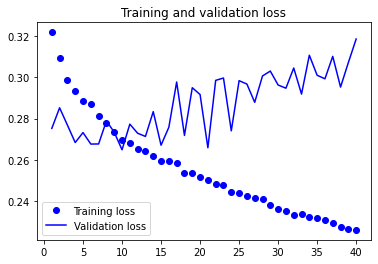

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# Stacking recurrent layers

In [23]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop


model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40


/tmp/ipykernel_246330/877987082.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 806s 2s/step - loss: 0.3220 - val_loss: 0.2743
Epoch 2/40
500/500 [==============================] - 802s 2s/step - loss: 0.3013 - val_loss: 0.2743
Epoch 3/40
500/500 [==============================] - 863s 2s/step - loss: 0.2951 - val_loss: 0.2849
Epoch 4/40
500/500 [==============================] - 855s 2s/step - loss: 0.2883 - val_loss: 0.2682
Epoch 5/40
500/500 [==============================] - 864s 2s/step - loss: 0.2801 - val_loss: 0.2701
Epoch 6/40
500/500 [==============================] - 821s 2s/step - loss: 0.2754 - val_loss: 0.2787
Epoch 7/40
500/500 [==============================] - 813s 2s/step - loss: 0.2706 - val_loss: 0.2668
Epoch 8/40
500/500 [==============================] - 813s 2s/step - loss: 0.2654 - val_loss: 0.2787
Epoch 9/40
500/500 [==============================] - 814s 2s/step - loss: 0.2611 - val_loss: 0.2936
Epoch 10/40
500/500 [==============================] - 805s 2s/step - loss: 0.2523 - val_loss: 0.2869


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



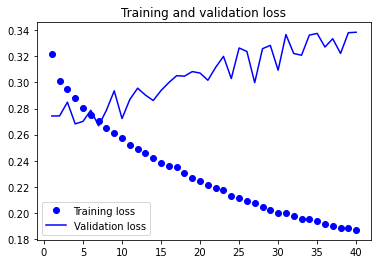

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# Using bidirectional RNNs
# A bidirectional RNN is a common RNN variant 
# that can offer greater performance than a regular RNN on certain tasks. 
# It’s frequently used in natural-language processing—you could call it 
# the Swiss Army knife of deep learning for natural-language processing.

In [25]:
from keras.datasets import imdb
from keras.utils.data_utils import pad_sequences
from keras import layers
from keras.models import Sequential


max_features = 10000
maxlen = 500
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)
model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 118s 742ms/step - loss: 0.5045 - acc: 0.7595 - val_loss: 0.7399 - val_acc: 0.7252
Epoch 2/10
157/157 [==============================] - 112s 714ms/step - loss: 0.3192 - acc: 0.8792 - val_loss: 0.3225 - val_acc: 0.8694
Epoch 3/10
157/157 [==============================] - 116s 739ms/step - loss: 0.2614 - acc: 0.9042 - val_loss: 0.3178 - val_acc: 0.8704
Epoch 4/10
157/157 [==============================] - 122s 775ms/step - loss: 0.2192 - acc: 0.9196 - val_loss: 0.4530 - val_acc: 0.8362
Epoch 5/10
157/157 [==============================] - 118s 754ms/step - loss: 0.1959 - acc: 0.9305 - val_loss: 0.3427 - val_acc: 0.8686
Epoch 6/10
157/157 [==============================] - 124s 788ms/step - loss: 0.1777 - acc: 0.9376 - val_loss: 0.3452 - val_acc: 0.8754
Epoch 7/10
157/157 [==============================] - 114s 729ms/step - loss: 0.1596 - acc: 0.9451 - val_loss: 0.5898 - val_acc: 0.7894
Epoch 8/10
157/157 [============================

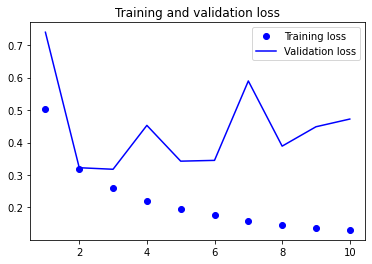

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# A bidirectional RNN exploits this idea to improve on the performance of chronological-order RNNs. 
# It looks at its input sequence both ways (see figure 6.25), obtaining potentially richer representations 
# and capturing patterns that may have been missed by the chronological-order version alone.

In [27]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 179s 1s/step - loss: 0.5378 - acc: 0.7279 - val_loss: 0.4683 - val_acc: 0.7892
Epoch 2/10
157/157 [==============================] - 188s 1s/step - loss: 0.3256 - acc: 0.8745 - val_loss: 0.3354 - val_acc: 0.8652
Epoch 3/10
157/157 [==============================] - 177s 1s/step - loss: 0.2658 - acc: 0.9022 - val_loss: 0.2985 - val_acc: 0.8854
Epoch 4/10
157/157 [==============================] - 166s 1s/step - loss: 0.2224 - acc: 0.9191 - val_loss: 0.3083 - val_acc: 0.8802
Epoch 5/10
157/157 [==============================] - 179s 1s/step - loss: 0.2039 - acc: 0.9248 - val_loss: 0.3517 - val_acc: 0.8516
Epoch 6/10
157/157 [==============================] - 177s 1s/step - loss: 0.1733 - acc: 0.9402 - val_loss: 0.7888 - val_acc: 0.8162
Epoch 7/10
157/157 [==============================] - 182s 1s/step - loss: 0.1607 - acc: 0.9464 - val_loss: 0.4359 - val_acc: 0.8706
Epoch 8/10
157/157 [==============================] - 181s 1s/step - 

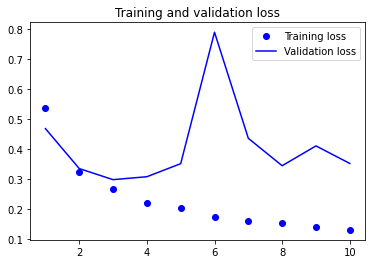

In [28]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [29]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop


model = Sequential()
model.add(layers.Bidirectional(
layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40


/tmp/ipykernel_246330/2505144191.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 300s 595ms/step - loss: 0.2914 - val_loss: 0.2616
Epoch 2/40
500/500 [==============================] - 300s 601ms/step - loss: 0.2771 - val_loss: 0.2712
Epoch 3/40
500/500 [==============================] - 302s 604ms/step - loss: 0.2720 - val_loss: 0.2784
Epoch 4/40
500/500 [==============================] - 299s 598ms/step - loss: 0.2679 - val_loss: 0.2574
Epoch 5/40
500/500 [==============================] - 303s 606ms/step - loss: 0.2614 - val_loss: 0.2616
Epoch 6/40
500/500 [==============================] - 308s 616ms/step - loss: 0.2557 - val_loss: 0.2776
Epoch 7/40
500/500 [==============================] - 289s 579ms/step - loss: 0.2512 - val_loss: 0.2551
Epoch 8/40
500/500 [==============================] - 306s 612ms/step - loss: 0.2444 - val_loss: 0.2713
Epoch 9/40
500/500 [==============================] - 298s 596ms/step - loss: 0.2364 - val_loss: 0.2845
Epoch 10/40
500/500 [==============================] - 289s 579ms/step - lo

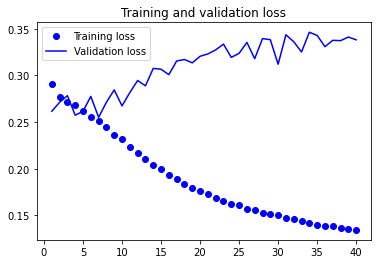

In [30]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()